# Lab Exercise #3 


In [31]:
#%pip install tensorflow
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install pydot
#%pip install scipy

## Dataset Validation

In [32]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## Hyperparameters


In [33]:
# For easy modification
image_size = (128, 128)
batch_size = 32
epochs = 30

## Loading the Dataset

In [34]:
import tensorflow as tf

# Load Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

# Load Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


## Data Profiling and Visualization

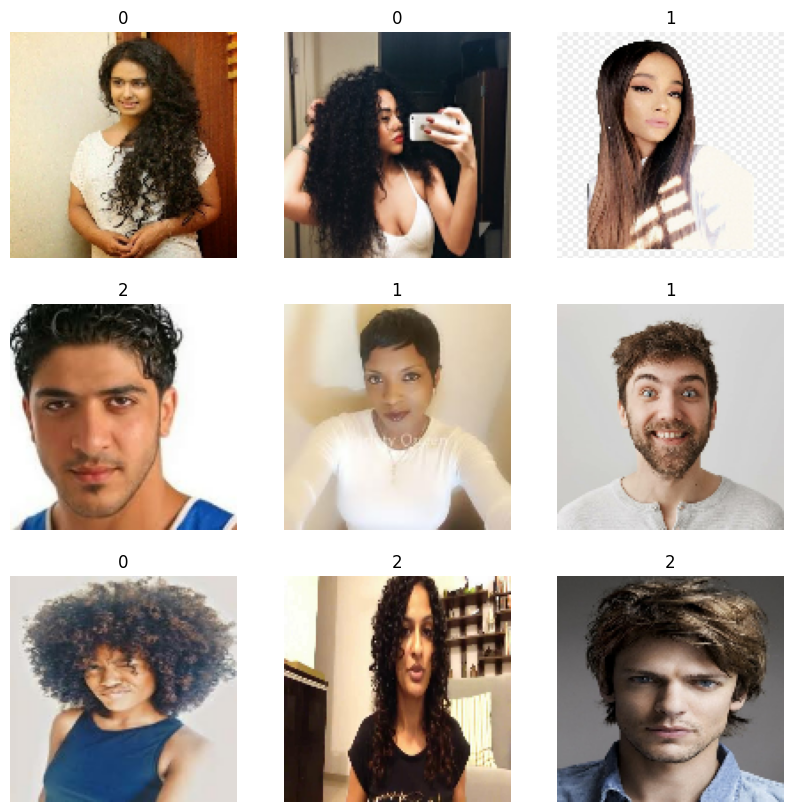

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle the dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in train_ds_shuffled.take(1):  # Take a batch of images from the shuffled dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

## Data Augmentation

In [36]:
import tensorflow as tf

def augment_data(image, label):
    #image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    #image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness randomly
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    image = random_rotate_image(image)
    return image, label


def random_rotate_image(image):
    random_angle = tf.random.uniform([], minval=0, maxval=12, dtype=tf.int32) * 30  # Generate a random angle between 0 and 330 degrees
    rotated_image = tf.image.rot90(image, k=random_angle // 90)   # Rotate the image by the random angle
    return rotated_image

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_data)


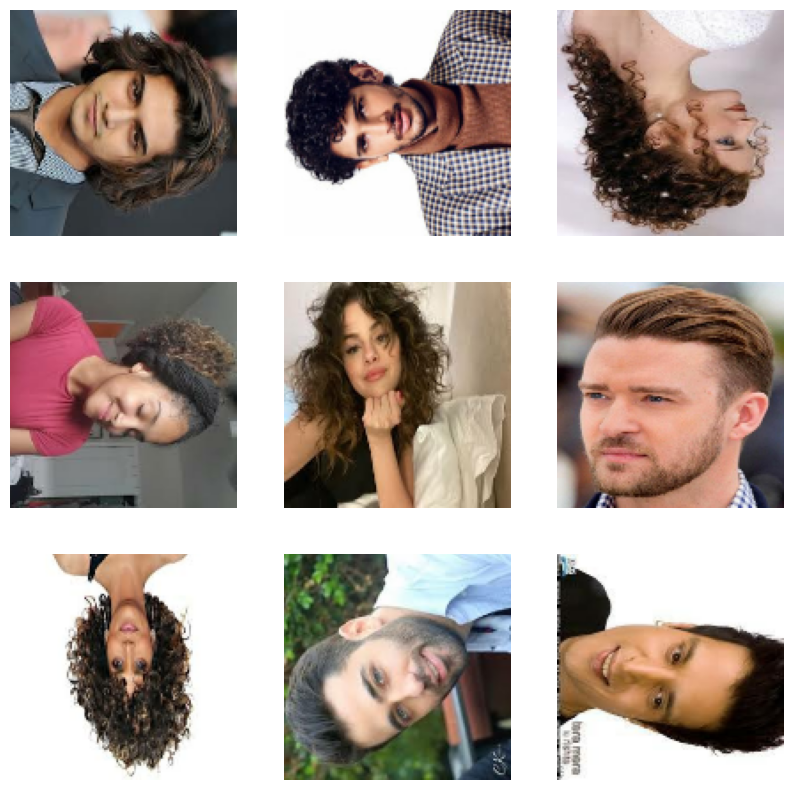

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images, _ = augment_data(images[i], None)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images).astype("uint8"))
        plt.axis("off")
plt.show()

#### GPU Optimization

In [38]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = augmented_train_ds.prefetch(tf_data.AUTOTUNE)
val_dataset = val_ds.prefetch(tf_data.AUTOTUNE)

## Model Architecture

In [39]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras import regularizers


# # Define your model architecture
# model = Sequential([
#     keras.Input(shape=image_size + (3,)),
#     layers.Rescaling(1.0 / 255),

#     layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.BatchNormalization(),
    
#     layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.BatchNormalization(),

#     layers.GlobalAveragePooling2D(),
    
#     layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.5),
#     layers.Dense(3, activation="softmax")
# ])

# # Compile the model
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )
# model.summary()


In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers

# Define your model architecture
model = Sequential([
    keras.Input(shape=image_size + (3,)),
    layers.Rescaling(1.0 / 255),

    layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.BatchNormalization(),
    
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(3, activation="softmax")
])


# Compile the model
model.compile(
    optimizer=keras.optimizers.Adamax(0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,699 (131.64 KB)

 Trainable params: 33,571 (131.14 KB)

 Non-trainable params: 128 (512.00 B)

In [41]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import layers

# # Load the pretrained VGG16 model without the top classification layers
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# # Freeze the pretrained layers
# base_model.trainable = False

# # Create a new model by adding your custom classification layers on top of the pretrained base
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     # Dropout(0.5),  # Adding dropout regularization
#     Dense(3, activation='softmax')
# ])

# # Compile the model with a lower learning rate

# model.compile(optimizer=keras.optimizers.Adam(1e-3),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=1e-6)


In [43]:
# Fine-tune the model
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.4461 - loss: 1.0866 - val_accuracy: 0.4000 - val_loss: 1.0923 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.4878 - loss: 1.0353 - val_accuracy: 0.3846 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.5407 - loss: 0.9823 - val_accuracy: 0.3692 - val_loss: 1.0961 - learning_rate: 2.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.5310 - loss: 0.9823 - val_accuracy: 0.3846 - val_loss: 1.0939 - learning_rate: 4.0000e-05
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.5404 - loss: 0.9893 - val_accuracy: 0.3846 - val_loss: 1.0920 - learning_rate: 8.0000e-06
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.5203 - loss: 1.0054 - val_accuracy: 0.3846 - val_loss: 1.0901 - learning_rate: 1.6000e-06
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.5300 -

## Model Evaluation

In [44]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
This image is 0.66 percent curly hair, 0.21 percent straight hair, and 0.12 percent wavy hair.


In [45]:
import os
import random

# Set the directory containing your dataset
dataset_dir = "hair_types/Curly_Hair/"

# Get a list of all files in the dataset directory
file_list = os.listdir(dataset_dir)

# Choose a random file from the list
random_file = random.choice(file_list)

# Construct the path to the randomly chosen image
image_path = os.path.join(dataset_dir, random_file)

# Load the image
img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)

# Print the results
print(
    "For the randomly chosen image (%s), the predicted percentages are: Curly Hair: %.2f%%, Straight Hair: %.2f%%, Wavy Hair: %.2f%%."
    % (random_file, predictions[0][0] * 100, predictions[0][1] * 100, predictions[0][2] * 100)
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
For the randomly chosen image (images181.jpg), the predicted percentages are: Curly Hair: 20.70%, Straight Hair: 48.68%, Wavy Hair: 30.62%.
